# Univariate linear regression

In this section, we introduce the default PSM in `cfr` based on univariate linear regression.
It can be applied to any proxy type that is believed to have a univariate linear relationship with a certain climate variable.
It also supports a seasonality searching procedure to help determine the seasonality of a specific site.

For instance, this PSM can be applied to the `tree.MXD` records, which we believe have high linear correlation with the local temperature condition over a growing season.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import os

## Data preparation

### Proxy

In [2]:
pdb = cfr.ProxyDatabase().fetch('PAGES2kv2')

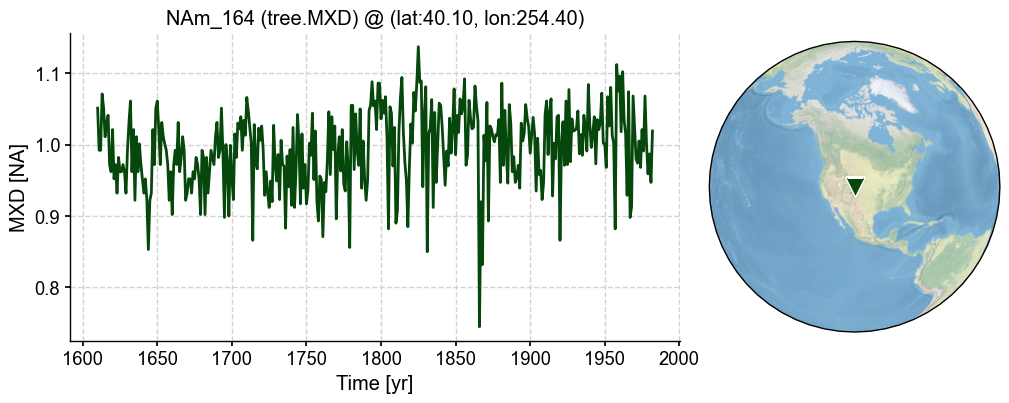

In [3]:
pobj = pdb.records['NAm_164']
fig, ax = pobj.plot()

### Model

In [4]:
model_tas = cfr.ClimateField().fetch('iCESM_past1000historical/tas')
model_pr = cfr.ClimateField().fetch('iCESM_past1000historical/pr')

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


In [5]:
model_tas.da

<xarray.DataArray 'tas' (time: 13872, lat: 96, lon: 144)>
[191766528 values with dtype=float32]
Coordinates:
  * time     (time) object 0850-01-17 00:00:00 ... 2005-12-17 00:00:00
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  Reference height temperature
    units:      K

In [6]:
print(np.median(np.diff(model_tas.da.lat)))
print(np.median(np.diff(model_tas.da.lon)))

1.8947372
2.5


### Instrumental observations

In [7]:
obs_tas = cfr.ClimateField().fetch('CRUTSv4.07/tas', vn='tmp')
obs_pr = cfr.ClimateField().fetch('CRUTSv4.07/pr', vn='pre')

Fetching data: 100%|██████████| 163M/163M [01:36<00:00, 1.77MiB/s] 


>>> Downloaded file saved at: ./data/cru_ts4.07.1901.2022.tmp.dat.nc.gz


Fetching data: 100%|██████████| 225M/225M [02:04<00:00, 1.89MiB/s]   


>>> Downloaded file saved at: ./data/cru_ts4.07.1901.2022.pre.dat.nc.gz


In [8]:
obs_tas = obs_tas.rename('tas')
obs_pr = obs_pr.rename('pr')

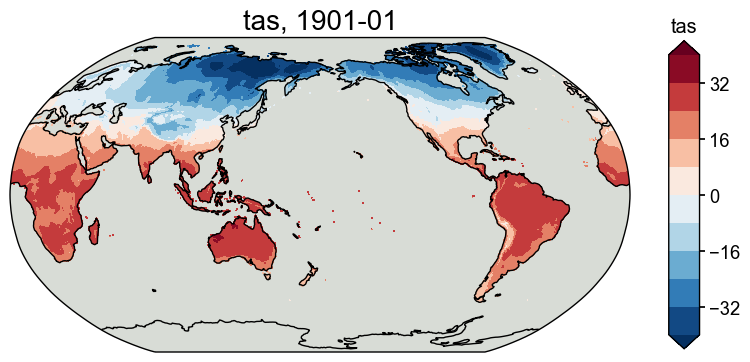

In [9]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

In [11]:
obs_tas_new = obs_tas.wrap_lon()

In [12]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) object 1901-01-16 00:00:00 ... 2022-12-16 00:00:00

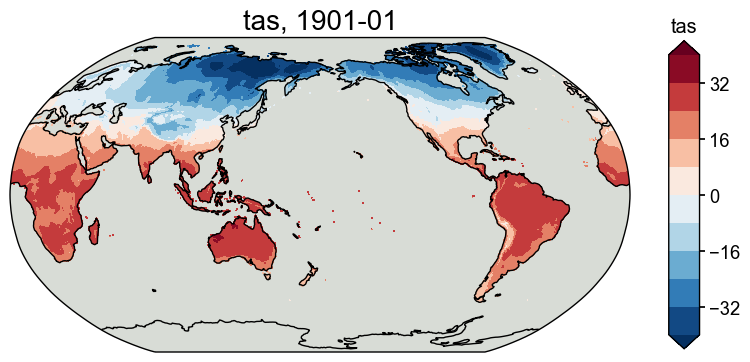

In [13]:
fig, ax = obs_tas_new.plot(levels=np.linspace(-40, 40, 11))

In [14]:
obs_pr.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) object 1901-01-16 00:00:00 ... 2022-12-16 00:00:00

In [15]:
obs_pr_new = obs_pr.wrap_lon()

In [16]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) object 1901-01-16 00:00:00 ... 2022-12-16 00:00:00

## Get climate data for a specific `ProxyRecord`

In [17]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

CPU times: user 9.65 ms, sys: 198 ms, total: 207 ms
Wall time: 2.3 s


In [18]:
pobj.clim['obs.tas'].da

<xarray.DataArray 'tas' (time: 1464)>
array([ -9.5     , -11.8     ,  -8.1     , ...,   2.5     ,  -6.3     ,
        -9.400001], dtype=float32)
Coordinates:
    lon      float32 254.2
    lat      float32 40.25
  * time     (time) object 1901-01-16 00:00:00 ... 2022-12-16 00:00:00
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [19]:
lr_mdl = cfr.psm.Linear(pobj)

In [20]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list=sn_list)

CPU times: user 121 ms, sys: 29.3 ms, total: 150 ms
Wall time: 152 ms


In [21]:
lr_mdl.calib_details

{'df':         proxy        tas
 time                    
 1901.0  1.013  10.933333
 1902.0  1.038   9.900001
 1903.0  1.014   9.733334
 1904.0  0.935   8.933333
 1905.0  1.009  10.166667
 ...       ...        ...
 1978.0  1.001  10.666667
 1979.0  0.959  10.366667
 1980.0  0.987  11.700000
 1981.0  0.947  11.266666
 1982.0  1.019  10.433333
 
 [82 rows x 2 columns],
 'nobs': 82.0,
 'fitR2adj': 0.20442391329166198,
 'PSMresid': time
 1901.0   -0.004534
 1902.0    0.050338
 1903.0    0.031156
 1904.0   -0.024717
 1905.0    0.013629
             ...   
 1978.0   -0.008825
 1979.0   -0.042152
 1980.0   -0.052697
 1981.0   -0.080170
 1982.0    0.015920
 Length: 82, dtype: float64,
 'PSMmse': 0.0019213288992947159,
 'SNR': 0.5221711278110613,
 'seasonality': [6, 7, 8]}

In [22]:
%%time
pp = lr_mdl.forward()

CPU times: user 121 ms, sys: 42 ms, total: 163 ms
Wall time: 159 ms


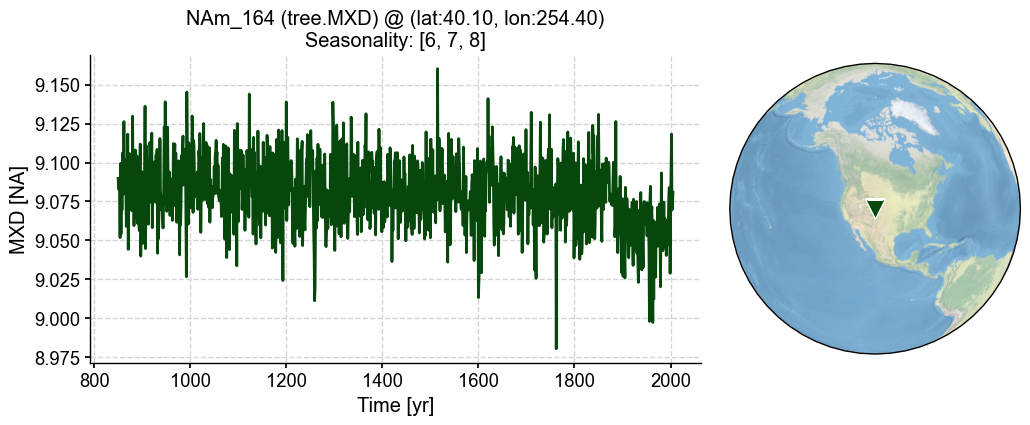

In [23]:
fig, ax = pp.plot()